# TP 8 : ICA, PCA, NMF
### Robin Masliah

In [8]:
import wave
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np
from sklearn import decomposition
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.datasets import fetch_olivetti_faces
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import warnings
from time import time 
from sklearn.feature_extraction import text 
from sklearn import decomposition
from sklearn import datasets

### Question 1, 2 et 3

In [65]:
# -- Read audio data ----------------------------------------------------------


def wavread(filename):
    """Read .wav file"""
    wf = wave.open(filename)
    s = np.fromstring(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s


def wavwrite(filename, s, nchannels=1):
    """Write .wav file"""
    wf = wave.open(filename, 'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s / np.max(np.abs(s)) * 2 ** 14  # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()

s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')

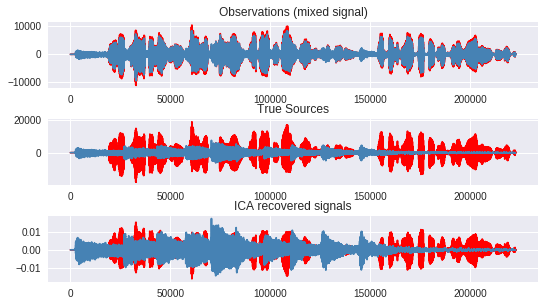

In [66]:
# -- Create stereo mix --------------------------------------------------------

nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]
# Mixing matrix
A = np.array([[0.6, 0.5],
             [0.4, 0.5]])
# Do the mix
X = S.dot(A)
# Write mix file
x = np.zeros(2 * nsmp)
x[::2] = X[:, 0]
x[1::2] = X[:, 1]
wavwrite('./snd/mix.wav', x, nchannels=2)

# -- ICA source separation ----------------------------------------------------
# Compute ICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# Visualise sources
plt.figure()

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

# Write audio sources
s1_ = S_[:, 1]
s2_ = S_[:, 0]
wavwrite('./snd/clavesin.wav', s1_)
wavwrite('./snd/homme.wav', s2_)

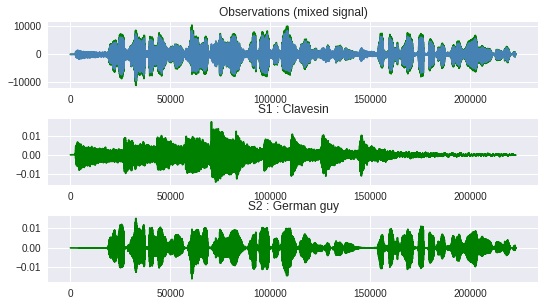

In [67]:

# Visualise sources
plt.figure()

models = [X, np.c_[s1_], np.c_[s2_]]
names = ['Observations (mixed signal)',
         'S1 : Clavesin',
         'S2 : German guy']
colors = ['green', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()


Je remarque ici que le fit transform inverse parfois les signaux.

### 1) Étudier et tester le script pca_nmf_faces.py . Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA.

Dataset consists of 400 faces
2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels


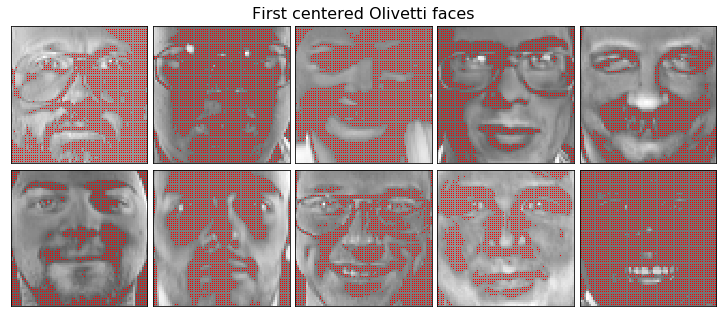

Extracting the top 10 Eigenfaces - PCA...
(400, 4096)
(400, 10)
done in 0.509s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1884 negative-valued pixels
2221 negative-valued pixels
2129 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
(400, 4096)
(400, 10)
done in 8.808s


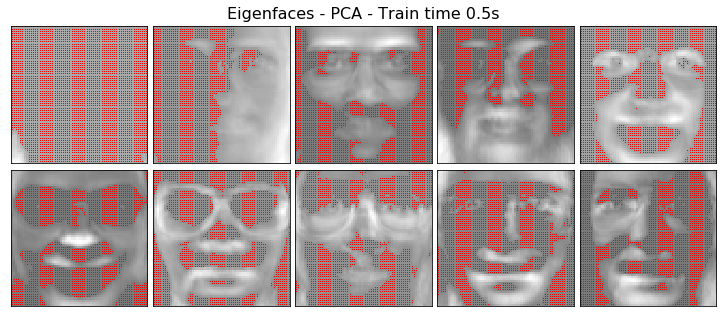

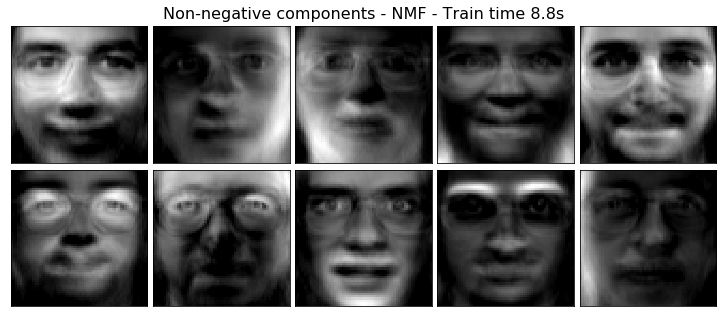

In [4]:
#  Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# -- Prepare data and define utility functions --------------------------------

warnings.filterwarnings("ignore")
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

print("Dataset consists of %d faces" % n_samples)

def plot_gallery(title, images):
    """Plot images as gallery"""
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i+1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp < 0)
        if len(dmy[0]) > 0:
            yz, xz = dmy
        comp[comp < 0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0]) > 0:
            plt.plot(xz, yz, 'r,', hold=True)
            print(len(dmy[0]), "negative-valued pixels")

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)



# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

plt.show()
# -- Decomposition methods ----------------------------------------------------

# List of the different estimators and whether to center the data
estimators = [
        ('pca', 'Eigenfaces - PCA',
         decomposition.PCA(n_components=n_components, whiten=True),
         True),

        ('nmf', 'Non-negative components - NMF',
         decomposition.NMF(n_components=n_components, init=None, tol=1e-6,
                            max_iter=1000),
         False)
    ]

# -- Transform and classify ---------------------------------------------------

labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()

    data = X
    if center:
        data = X_
    print(data.shape)
    data = estimator.fit_transform(data)
    print(data.shape)

    clf = LinearDiscriminantAnalysis()
    scores = cross_val_score(clf, data, labels, cv=5)

    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)

    components_ = estimator.components_

    plot_gallery('%s - Train time %.1fs' % (name, train_time),
             components_[:n_components])
plt.show()

### 2) Modifier le script pour réaliser une évaluation des performances d'un système de reconnaissance automatique de visages utilisant les caractéristiques extraites par PCA, comparées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA pour la classification. On effectuera l'évaluation par validation croisée. On observera l'évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.

In [5]:
# -- Decomposition methods ----------------------------------------------------
# List of the different estimators and whether to center the data
cv_score_pca = []
cv_score_nmf = []
for n_components in range(5, 50, 5):
    estimators = [
        ('pca', 'Eigenfaces - PCA',
         decomposition.PCA(n_components=n_components, whiten=True),
         True),

        ('nmf', 'Non-negative components - NMF',
         decomposition.NMF(n_components=n_components, init=None, tol=1e-6,
                           max_iter=1000),
         False)
    ]

    # -- Transform and classify ---------------------------------------------------

    labels = dataset.target
    X = faces
    X_ = faces_centered

    for shortname, name, estimator, center in estimators:

        print("Extracting the top %d %s..." % (n_components, name))
        t0 = time()

        data = X
        if center:
            data = X_
        print(data.shape)
        data = estimator.fit_transform(data)
        print(data.shape)

        clf = LinearDiscriminantAnalysis()
        scores = cross_val_score(clf, data, labels, cv=5)

        if shortname == "pca":
            cv_score_pca.append(np.mean(scores))
        if shortname == "nmf":
            cv_score_nmf.append(np.mean(scores))

        train_time = (time() - t0)
        print("done in %0.3fs" % train_time)

        components_ = estimator.components_

Extracting the top 5 Eigenfaces - PCA...
(400, 4096)
(400, 5)
done in 0.146s
Extracting the top 5 Non-negative components - NMF...
(400, 4096)
(400, 5)
done in 7.152s
Extracting the top 10 Eigenfaces - PCA...
(400, 4096)
(400, 10)
done in 0.108s
Extracting the top 10 Non-negative components - NMF...
(400, 4096)
(400, 10)
done in 8.167s
Extracting the top 15 Eigenfaces - PCA...
(400, 4096)
(400, 15)
done in 0.219s
Extracting the top 15 Non-negative components - NMF...
(400, 4096)
(400, 15)
done in 10.358s
Extracting the top 20 Eigenfaces - PCA...
(400, 4096)
(400, 20)
done in 0.223s
Extracting the top 20 Non-negative components - NMF...
(400, 4096)
(400, 20)
done in 10.671s
Extracting the top 25 Eigenfaces - PCA...
(400, 4096)
(400, 25)
done in 0.146s
Extracting the top 25 Non-negative components - NMF...
(400, 4096)
(400, 25)
done in 12.193s
Extracting the top 30 Eigenfaces - PCA...
(400, 4096)
(400, 30)
done in 0.151s
Extracting the top 30 Non-negative components - NMF...
(400, 4096)


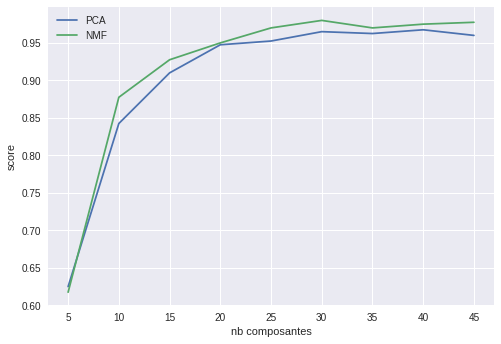

In [15]:
plt.plot(range(5,50,5), cv_score_pca, label="PCA")
plt.plot(range(5,50,5), cv_score_nmf, label="NMF")
plt.xlabel("nb composantes")
plt.ylabel("score")
plt.legend(loc="best")
plt.show()

- La NMF donne de meilleurs résultats mais la PCA est beaucoup plus rapide.
- On constate également que le nombre de composants joue sur la pérformance du modèle et cela jusqu'à certain niveau. Au dela de 30 composants le score ne s'améliore plus. On peut conclure qu'on passsant d'un paramètre de 30 à 45 composants le temps de calcul augmente considérablement. 

In [7]:
n_samples = 1000
n_features = 900
n_topics = 10 
n_top_words = 20

# Load the 20 newsgroups dataset and vectorize it using the most common word 
# frequency with TF-IDF weighting (without top 5% stop words)

t0 = time() 
print ("Loading dataset and extracting TF-IDF features...")
dataset = datasets.fetch_20newsgroups(data_home='c:/tmp/',shuffle=True, random_state=1)
vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features) 
counts = vectorizer.fit_transform(dataset.data[:n_samples]) 
tfidf = text.TfidfTransformer().fit_transform(counts) 
print ("done in %0.3fs." % (time() - t0))
# Fit the NMF model

print ("Fitting the NMF model on with n_samples=%d and n_features=%d..." % (n_samples, n_features))
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf) 
print ("done in %0.3fs." % (time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(nmf.components_): 
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Loading dataset and extracting TF-IDF features...
done in 1.074s.
Fitting the NMF model on with n_samples=1000 and n_features=900...
done in 1.642s.
Topic #0:
the of in and on was to as at is which by were one with for they that when two

Topic #1:
chip clipper key the to encryption keys government be will this public as is or of can that it use

Topic #2:
is that of to not are and the we in as be people they it this there or god their

Topic #3:
edu university host posting cs nntp of re in article cc writes reply distribution washington cwru state mit for anyone

Topic #4:
com hp in article writes inc netcom corp stratus re sun posting nntp host dec ca jim org that corporation

Topic #5:
he his was to and him that who the had my in it but year this ca me team be

Topic #6:
uk ac co of university ___ dc posting host nntp thanks __ sorry college it please where return sun writes

Topic #7:
you to it your my have can if do and that car get like with don on what just so

Topic #8:
nasa go